In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def prepare_cifar10_dataloaders_for_vision_transformer_training_with_augmentation_and_normalization(batch_size: int = 64, image_size: int = 224, num_workers: int = 4):
    transformation_pipeline_for_training_data = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(image_size, padding=4),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
    ])

    transformation_pipeline_for_validation_data = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
    ])

    cifar10_training_dataset_with_transforms = datasets.CIFAR10(root='./data', train=True, download=True, transform=transformation_pipeline_for_training_data)
    cifar10_validation_dataset_with_transforms = datasets.CIFAR10(root='./data', train=False, download=True, transform=transformation_pipeline_for_validation_data)

    training_data_loader_with_batches_and_shuffling = DataLoader(dataset=cifar10_training_dataset_with_transforms, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    validation_data_loader_with_batches_and_no_shuffling = DataLoader(dataset=cifar10_validation_dataset_with_transforms, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return training_data_loader_with_batches_and_shuffling, validation_data_loader_with_batches_and_no_shuffling
training_data_loader, val_loader = prepare_cifar10_dataloaders_for_vision_transformer_training_with_augmentation_and_normalization()

100%|██████████| 170M/170M [00:05<00:00, 33.2MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [56]:
from torch import nn

class PositionalEmbedding(nn.Module):
    def __init__(self, number_of_patches: int, embedding_dimension: int):
        super(PositionalEmbedding, self).__init__()
        self.embedding_tensor = nn.Parameter(torch.zeros(1, number_of_patches + 1, embedding_dimension))

    def forward(self, input_tensor_with_patch_embeddings_and_cls_token: torch.Tensor):
        return input_tensor_with_patch_embeddings_and_cls_token + self.embedding_tensor

class VITModel(torch.nn.Module):
    def __init__(self, num_classes: int = 10, transformer_embedding_dim=1024, transformer_head_count=4, patch_size=16, patch_count=14 * 14, hidden_dim = 256):
        super(VITModel, self).__init__()
        self.patch_size = patch_size
        self.patch_count = patch_count
        self.linear_projection_layer = nn.Linear(in_features=16*16*3, out_features=1024)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_embedding_dim, nhead=transformer_head_count, batch_first=True)
        self.positional_embedding_layer = PositionalEmbedding(number_of_patches=patch_count, embedding_dimension=transformer_embedding_dim)
        self.mlp_head = nn.Sequential(
            nn.Linear(in_features=transformer_embedding_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=num_classes)
        )
        self.softmax = nn.Softmax(dim=1)
        self.class_token = nn.Parameter(torch.zeros(1, 1, transformer_embedding_dim))
    def forward(self, x: torch.Tensor):
        batch_size, channels, height, width = x.shape
        class_token = self.class_token.expand(batch_size, -1, -1)
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(batch_size, 3, self.patch_count, self.patch_size, self.patch_size)
        patches = patches.permute(0, 2, 1, 3, 4).contiguous().view(batch_size, self.patch_count, -1)
        print(class_token.shape, patches.shape)
        x = self.linear_projection_layer(patches)
        x = torch.cat((class_token, x), dim=1)
        x = self.positional_embedding_layer(x)
        x = self.transformer_encoder_layer(x)
        x = x[:, 0]
        x = self.mlp_head(x)
        #x = self.softmax(x)
        return x

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VITModel(num_classes=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
loss_function = nn.CrossEntropyLoss()

In [59]:
for epoch in range(10):
    model.train()
    for images, labels in training_data_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        print(loss)
        loss.backward()
        optimizer.step()


torch.Size([64, 1, 1024]) torch.Size([64, 196, 768])
tensor(2.0672, device='cuda:0', grad_fn=<NllLossBackward0>)
torch.Size([64, 1, 1024]) torch.Size([64, 196, 768])
tensor(2.0028, device='cuda:0', grad_fn=<NllLossBackward0>)
torch.Size([64, 1, 1024]) torch.Size([64, 196, 768])
tensor(2.1246, device='cuda:0', grad_fn=<NllLossBackward0>)
torch.Size([64, 1, 1024]) torch.Size([64, 196, 768])
tensor(2.1070, device='cuda:0', grad_fn=<NllLossBackward0>)
torch.Size([64, 1, 1024]) torch.Size([64, 196, 768])
tensor(2.0235, device='cuda:0', grad_fn=<NllLossBackward0>)
torch.Size([64, 1, 1024]) torch.Size([64, 196, 768])
tensor(2.1766, device='cuda:0', grad_fn=<NllLossBackward0>)
torch.Size([64, 1, 1024]) torch.Size([64, 196, 768])
tensor(1.9951, device='cuda:0', grad_fn=<NllLossBackward0>)
torch.Size([64, 1, 1024]) torch.Size([64, 196, 768])
tensor(2.0628, device='cuda:0', grad_fn=<NllLossBackward0>)
torch.Size([64, 1, 1024]) torch.Size([64, 196, 768])
tensor(1.9602, device='cuda:0', grad_fn=<Nl

KeyboardInterrupt: 

In [ ]:
for data, labels in training_data_loader:
  break

Images are normalized as is typically the standard for imagenet data. Hence the weird visualization.

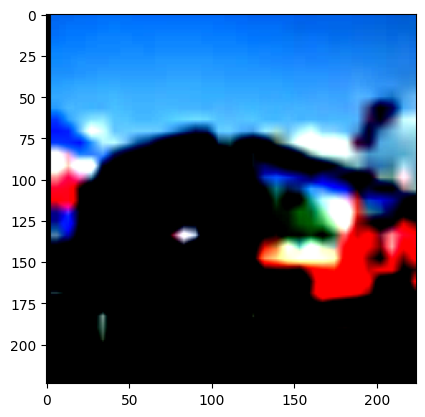

In [42]:
import matplotlib.pyplot as plt
plt.imshow(images[0].cpu().detach().permute(1, 2, 0).numpy())

In [43]:
model(images)[0]

tensor([ 0.0457,  0.8991, -0.1783,  0.1280, -0.7109, -0.3662, -0.8313, -0.2766,
         0.8876,  1.0151], device='cuda:0', grad_fn=<SelectBackward0>)

In [44]:
labels[0]

tensor(9, device='cuda:0')

In [47]:
model(images)[6]

tensor([-1.5286, -0.5515,  0.4892,  0.7693,  0.7535,  0.4649,  1.5760,  0.6172,
        -2.5499, -0.8722], device='cuda:0', grad_fn=<SelectBackward0>)

In [48]:
labels[6]

tensor(6, device='cuda:0')

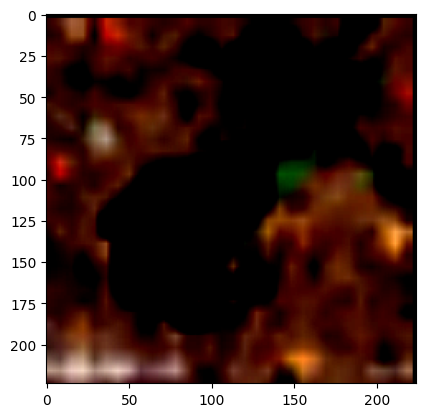

In [49]:
plt.imshow(images[6].cpu().detach().permute(1, 2, 0).numpy())